### Question 1 RANSAC-based Image Stiching ### 
- I have used FlannBasedMatcher for finding the matching points along them and thresholded them using the value that I saw fit


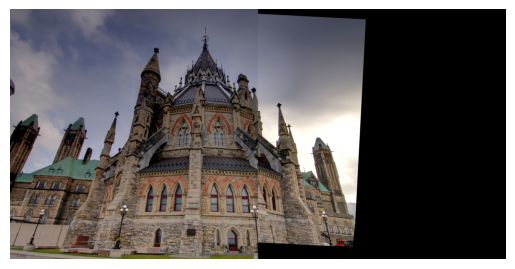

In [2]:
import numpy as np
import cv2 as cv
import kornia
import torch
import math
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import skimage.transform as skt

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :param inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

  
    for inlier_pair in inliers:
        x1, y1, x2, y2 = inlier_pair
        ax.plot(x1, y1, '+r')
        ax.plot(x2 + img1.shape[1], y2, '+r') 
        ax.plot([x1, x2 + img1.shape[1]],
                [y1, y2], 'r', linewidth=0.4) 
    ax.axis('off')

def RANSAC(matches, inlier_threshold, min_pairs):
    """
    RANSAC algorithm for robust estimation of affine transformation between images
    :param matches: Matches between keypoints in two images
    :param inlier_threshold: Maximum allowable distance between matched points to be considered inliers
    :param min_pairs: Minimum number of matched pairs required for estimation
    :return: Best estimated affine transformation and the count of inliers
    """
    # Number of iterations for RANSAC
    num_iterations = 1000  
    # Initializing variables to keep track of inliers
    inliers_count = 0
    most_inliers = 0
    # Looping through iterations to find the best affine transformation
    for _ in range(num_iterations):
        # Randomly select a subset of matches
        subset_indices = np.random.choice(len(matches), min_pairs, replace=False)
        subset_matches = matches[subset_indices]
        
        # Extract source and destination points from the subset
        src_pts = np.float32([m[:2] for m in subset_matches])
        dst_pts = np.float32([m[2:] for m in subset_matches])
        # Estimate affine transformation using the subset
        affine = cv.getAffineTransform(src_pts, dst_pts)

        # Transform source points using estimated affine transformation
        transformed_pts = cv.transform(np.array([src_pts]), affine).squeeze()
        
        # Calculate distances between transformed points and destination points
        distances = np.linalg.norm(transformed_pts - dst_pts, axis=1)
        
        # Count inliers based on distances
        for distance in distances:
            if distance < inlier_threshold:
                inliers_count += 1
        
        # Update if the current model has more inliers
        if inliers_count > most_inliers:
            most_inliers = inliers_count
            best_affine = affine
    
    return best_affine, most_inliers
    
def create_panorama(img1, img2, affine_transformation):
    """
    Create a panorama by warping the second image onto the first image using the estimated transformation
    :param img1: First image
    :param img2: Second image
    :param affine_transformation: Estimated affine transformation
    :return: Panorama image
    """
    # Warp the second image onto the first image using the estimated transformation
    warped_img2 = cv.warpAffine(img2, affine_transformation, (img1.shape[1], img1.shape[0]))

    # Create an empty canvas for the panorama
    panorama = np.zeros((max(img1.shape[0], warped_img2.shape[0]), img1.shape[1] + warped_img2.shape[1], 3), dtype=np.uint8)

    # Place the first image on the left side of the panorama
    panorama[:img1.shape[0], :img1.shape[1]] = img1
    # Place the warped second image on the right side of the panorama
    panorama[:warped_img2.shape[0], img1.shape[1]:] = warped_img2

    return panorama

# Load images
img = cv.imread('parliament-left.jpg')
img_2 = cv.imread('parliament-right.jpg')

# Padding the second image to match resolutions (manually adjusted)
img_2 = cv.copyMakeBorder(img_2, 90, 85, 145, 145, borderType=0, value=1)

# Convert images to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_2 = cv.cvtColor(img_2, cv.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors using SIFT
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)
kp_2, des_2 = sift.detectAndCompute(gray_2, None)

# Convert descriptors to torch tensors
des_torch = torch.from_numpy(des).float()
des2_torch = torch.from_numpy(des_2).float()

# Performing matching of the descriptors using FLANN
matches = cv.FlannBasedMatcher().knnMatch(des, des_2, k=2)

# Threshold matches based on Lowe's ratio test
matchesPairs = []
pairs_thresholded = []
threshold = 0.09
for i, j in matches:
    if i.distance < threshold * j.distance:
        pairs_thresholded.append([i])

for p in pairs_thresholded:
    matchesPairs.append(list(kp[p[0].queryIdx].pt + kp_2[p[0].trainIdx].pt))

matches_ARR = np.array(matchesPairs)

# RANSAC to estimate affine transformation
affine_transformation, most_inliers = RANSAC(matches_ARR, 0.0001, 3)  # Minimum number of pairs required: 3

# panorama using the estimated affine transformation
panorama = create_panorama(img, img_2, affine_transformation)


plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### QUESTION 2 ###
- Part B
- unfortunately I was not able to fully attatch the three images together but I was able to find the homography from middle to left and right picture
 to the midlle one Using the calculated points and matches from question 1 and displayed the results for images Left and middle also right and middle picture.  
- Thank you so much for giving me your time again to run my little code :)


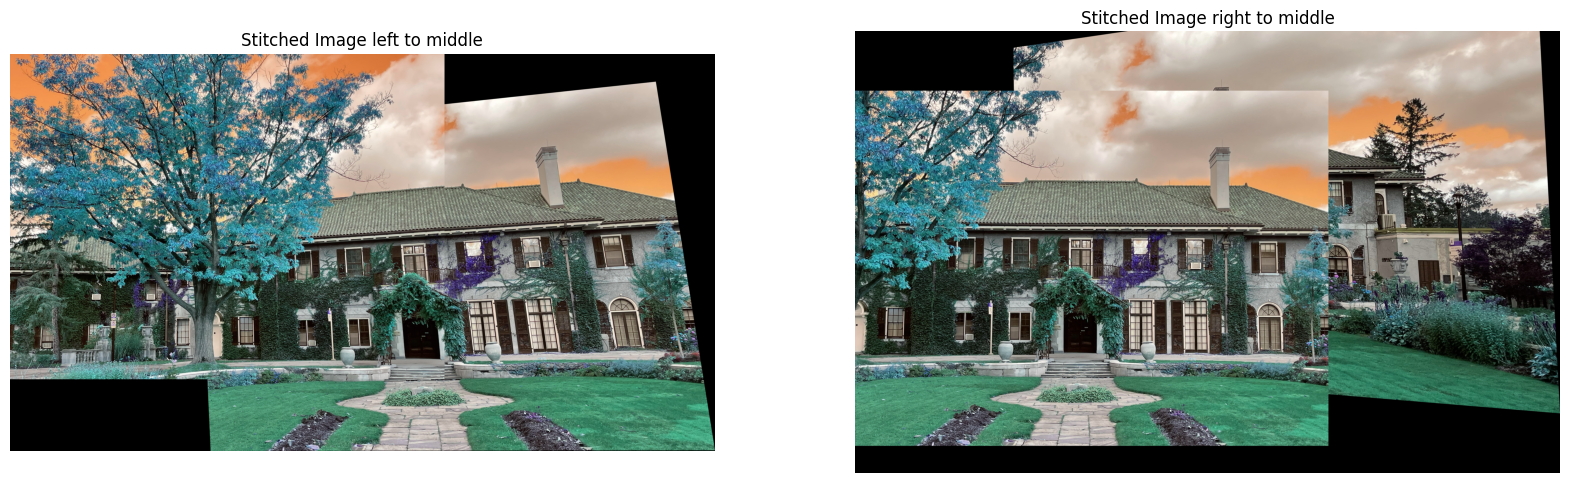

In [5]:
import numpy as np
import cv2 as cv
import kornia
import torch
import math
import random
from matplotlib import pyplot as plt

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :param inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

    for inlier_pair in inliers:
        x1, y1, x2, y2 = inlier_pair
        ax.plot(x1, y1, '+r')
        ax.plot(x2 + img1.shape[1], y2, '+r')
        ax.plot([x1, x2 + img1.shape[1]],
                [y1, y2], 'r', linewidth=0.4)
    ax.axis('off')


def HOMOGRAPHY_RANSAC(matches, threshold, iters):
    best_inliers = 0
    best_H = None
    indexP = random.sample(range(len(matches)), 4)
    point = [matches[i] for i in indexP ]
    pairs = np.array(point)
    p1 = pairs[:, :2]  # Points in the first image
    p2 = pairs[:, 2:]  # Points in the second image
    
    # Construct the matrix A for the linear equation system
    A = []
    for i in range(len(p1)):
        x, y = p1[i]
        u, v = p2[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.array(A)
    
    # Singular Value Decomposition (SVD) to solve for the homography matrix
    U, s, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    
    # Normalize the homography matrix
    H /= H[2, 2]
    
    all_p1 = np.hstack((matches[:, :2], np.ones((len(matches), 1))))
    all_p2 = matches[:, 2:4]

    # Applying transformation to all points simultaneously
    transformed_points = np.dot(H, all_p1.T).T

    # Converting homogeneous coordinates to Cartesian and computing errors
    p2_es = transformed_points[:, :2] / transformed_points[:, [2]]
    distance_diff = np.linalg.norm(all_p2 - p2_es, axis=1) ** 2

    index = np.where(distance_diff < threshold)[0]
    INL = matches[index]

    NUMInliers = len(INL)
    if NUMInliers > best_inliers:
        best_inliers = INL.copy()
        best_inliers = NUMInliers
        best_H = H.copy()
        
        if best_H is None:
            return H
        else:
            return best_H

    return H


def stitch_images(image1, image2, H):
    """Stitching the two images using the homography matrix."""
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    # Projecting the corners of the second image to the first image
    corners1 = np.array([[0, 0], [0, h1], [w1, h1], [w1, 0]], dtype=np.float32)
    corners2 = np.array([[0, 0], [0, h2], [w2, h2], [w2, 0]], dtype=np.float32)

    # Projecting the corners of the second image to the first image using homography matrix
    corners2_transformed = cv.perspectiveTransform(corners2.reshape(-1, 1, 2), H)
    corners_concat = np.concatenate((corners1, corners2_transformed[:, 0, :]), axis=0)

    # Finding the minimum and maximum coordinates for the stitched image
    min_x = int(np.min(corners_concat[:, 0]))
    max_x = int(np.max(corners_concat[:, 0]))
    min_y = int(np.min(corners_concat[:, 1]))
    max_y = int(np.max(corners_concat[:, 1]))

    # Offsets for image1 in the stitched image
    offset_x = -min_x
    offset_y = -min_y

    # Warping image2 to image1 using homography matrix
    warped_image2 = cv.warpPerspective(image2, H, (max_x - min_x, max_y - min_y))
    warped_image2[offset_y:h1 + offset_y, offset_x:w1 + offset_x] = image1

    return warped_image2   
    
img = cv.imread('Glendon-Hall-left.jpg')
img_2 = cv.imread('Glendon-Hall-middle.jpg')
img_3 = cv.imread('Glendon-Hall-right.jpg')

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_2 = cv.cvtColor(img_2, cv.COLOR_BGR2GRAY)
gray_3 = cv.cvtColor(img_3, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)
kp_2, des_2 = sift.detectAndCompute(gray_2, None)
kp_3, des_3 = sift.detectAndCompute(gray_3, None)

# Utilizing the FLANN-based matcher to find k-nearest matches between features in two images.
# matches contains a list of pairs of descriptors from both images with their respective distances.
matches_1_2 = cv.FlannBasedMatcher().knnMatch(des,des_2, k=2)
matches_2_3 = cv.FlannBasedMatcher().knnMatch(des_2, des_3, k=2)

#For the first two pictures
matchesPairs = []
pairs_thresholded = []
# threshold for distance be 0.18
threshold = 0.18
# looping through matches to threshold the distance with the given threshold
for i,j in matches_1_2:
    if i.distance < threshold*j.distance:
        pairs_thresholded.append([i])
        
# Match the pairs and add those matches to our matchesPairs list 
for p in pairs_thresholded:
    matchesPairs.append(list(kp[p[0].queryIdx].pt + kp_2[p[0].trainIdx].pt))
matches_ARR = np.array(matchesPairs)

#For the second two pictures 
matchesPairs_2 = []
pairs_thresholded_2 = []

# looping through matches to threshold the distance with the given threshold
for i,j in matches_2_3:
    if i.distance < threshold*j.distance:
        pairs_thresholded_2.append([i])
        
# Matching the pairs and add those matches to our matchesPairs list 
for p in pairs_thresholded_2:
    matchesPairs_2.append(list(kp_2[p[0].queryIdx].pt + kp_3[p[0].trainIdx].pt))
matches_ARR_2 = np.array(matchesPairs_2)

homography_1_2 = HOMOGRAPHY_RANSAC(matches_ARR, 0.000015, 1000)
homography_2_3 = HOMOGRAPHY_RANSAC(matches_ARR_2, 0.000015, 1000)

inverse_L = np.linalg.inv(homography_1_2)
inverse_R = np.linalg.inv(homography_2_3)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(stitch_images(img, img_2, inverse_L))
axs[0].set_title('Stitched Image left to middle')
axs[0].axis('off')

axs[1].imshow(stitch_images(img_2, img_3, inverse_R))
axs[1].set_title('Stitched Image right to middle')
axs[1].axis('off')

plt.show()